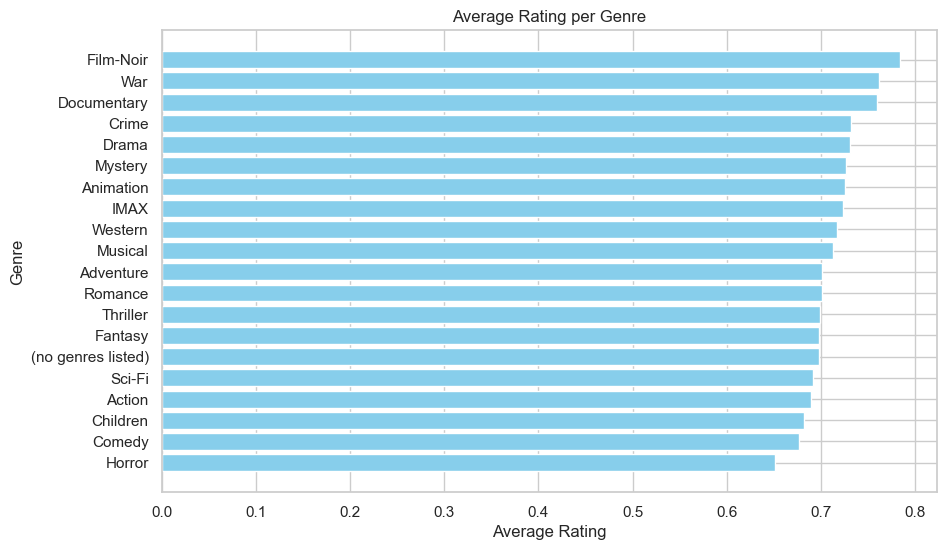

,_id,averageRating
0,Film-Noir,0.784023
1,War,0.761659
2,Documentary,0.759557
3,Crime,0.731659
4,Drama,0.731237
5,Mystery,0.726492
6,Animation,0.725987
7,IMAX,0.723667
8,Western,0.716788
9,Musical,0.712736


In [86]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["movies"]

# Execute the query 1
pipeline = [
    { "$unwind": "$genres" },
    { "$group": { "_id": "$genres", "averageRating": { "$avg": "$rating" } } },
    { "$sort": { "averageRating": -1 } }
]
average_ratings = list(db.movies_ratings.aggregate(pipeline))

# Convert to DataFrame
df = pd.DataFrame(average_ratings)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df['_id'], df['averageRating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating per Genre')
plt.gca().invert_yaxis()  # Invert y-axis to have highest rating on top
plt.show()
#1
df

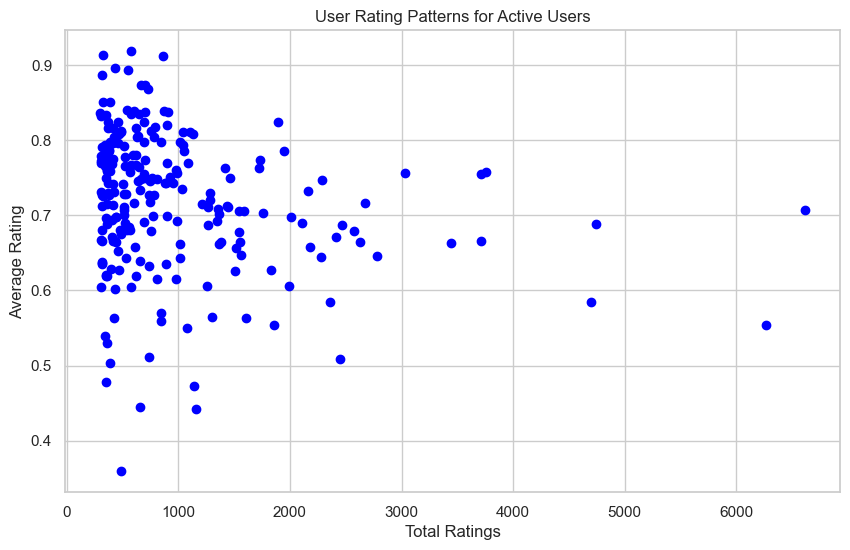

,_id,totalRatings,averageRating,mostRatedGenre
0,414,6616,0.707182,Drama
1,599,6266,0.553527,Drama
2,474,4739,0.687937,Drama
3,448,4702,0.584474,Comedy
4,380,3761,0.757581,Action


In [68]:
# Execute the query 2
pipeline = [
    { "$unwind": "$genres" },
    { "$group": { "_id": { "userId": "$userId", "genre": "$genres" }, "totalRatingsPerGenre": { "$sum": 1 }, "averageRatingPerGenre": { "$avg": "$rating" } } },
    { "$sort": { "_id.userId": 1, "totalRatingsPerGenre": -1 } },
    { "$group": { "_id": "$_id.userId", "totalRatings": { "$sum": "$totalRatingsPerGenre" }, "averageRating": { "$avg": "$averageRatingPerGenre" }, "mostRatedGenre": { "$first": "$_id.genre" } } },
    { "$match": { "totalRatings": { "$gt": 300 } } },
    { "$sort": { "totalRatings": -1 } }
]
user_patterns = list(db.movies_ratings.aggregate(pipeline))

# Convert to DataFrame
df_users = pd.DataFrame(user_patterns)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_users['totalRatings'], df_users['averageRating'], color='blue')
plt.xlabel('Total Ratings')
plt.ylabel('Average Rating')
plt.title('User Rating Patterns for Active Users')
plt.show()
df_users.head()

In [87]:

# MongoDB aggregation query 3
pipeline = [
    {
        "$group": {
            "_id": {"movieId": "$movieId", "movie": "$title"},
            "averageRating": {"$avg": "$rating"},
            "count": {"$sum": 1},
            "sumOfSquares": {"$sum": {"$pow": ["$rating", 2]}},
            "sumOfRatings": {"$sum": "$rating"}
        }
    },
    {
        "$project": {
            "averageRating": 1,
            "variance": {
                "$subtract": [
                    {"$divide": ["$sumOfSquares", "$count"]},
                    {"$pow": [{"$divide": ["$sumOfRatings", "$count"]}, 2]}
                ]
            }
        }
    },
    {"$sort": {"variance": -1}}
]

# Execute the query
result = list(db.movies_ratings.aggregate(pipeline))

# Convert to DataFrame
df = pd.DataFrame(result)

# Add a column for movie titles (extracted from the _id field)
df['movie'] = df['_id'].apply(lambda x: x['movie'])



# Fetch the top 10 most polarizing movies
top_movies = list(db.movies.aggregate(pipeline))[:10]
top_movie_ids = [movie['_id']['movieId'] for movie in top_movies]

df.head()


,_id,averageRating,variance,movie
0,"{'movieId': 2068, 'movie': 'Fanny and Alexande...",0.55,0.2025,Fanny and Alexander (Fanny och Alexander)
1,"{'movieId': 32892, 'movie': 'Ivan's Childhood ...",0.55,0.2025,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...
2,"{'movieId': 70946, 'movie': 'Troll 2'}",0.70,0.1800,Troll 2
3,"{'movieId': 84847, 'movie': 'Emma'}",0.50,0.1600,Emma
4,"{'movieId': 7564, 'movie': 'Kwaidan (Kaidan)'}",0.50,0.1600,Kwaidan (Kaidan)


<Figure size 200x100 with 0 Axes>

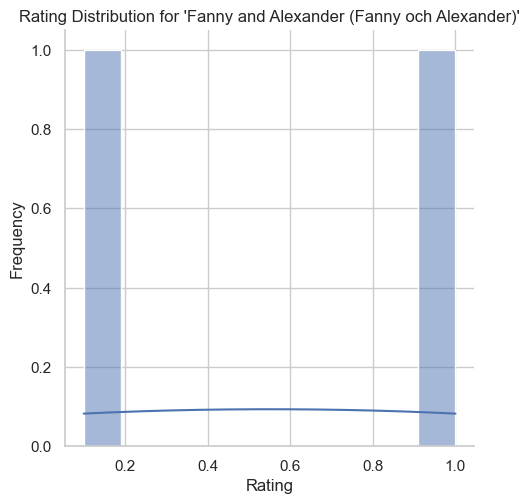

<Figure size 200x100 with 0 Axes>

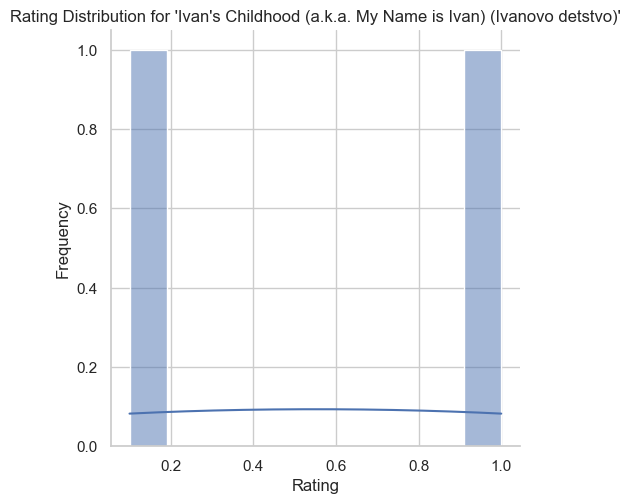

<Figure size 200x100 with 0 Axes>

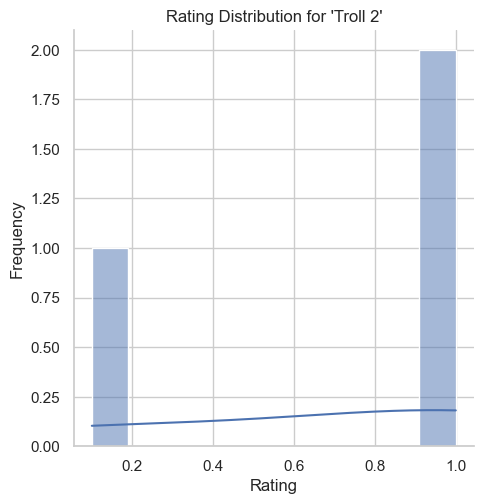

<Figure size 200x100 with 0 Axes>

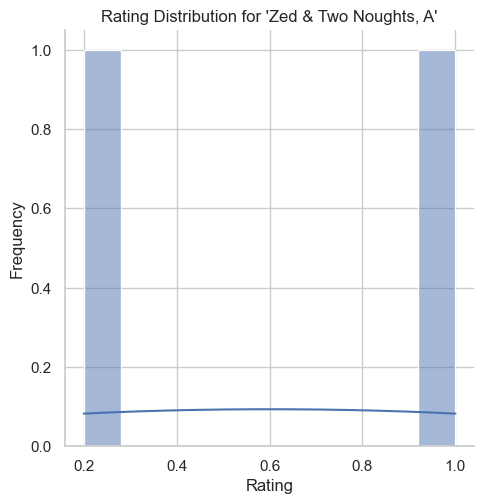

<Figure size 200x100 with 0 Axes>

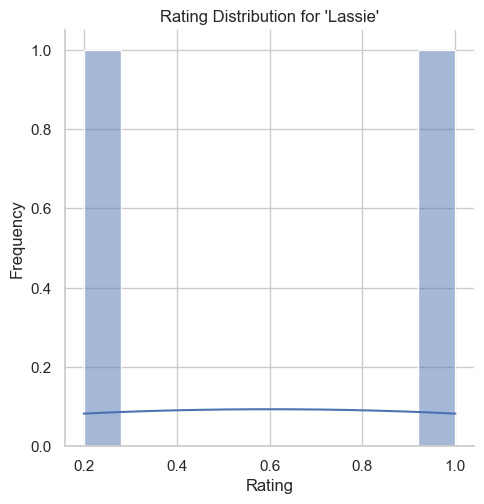

<Figure size 200x100 with 0 Axes>

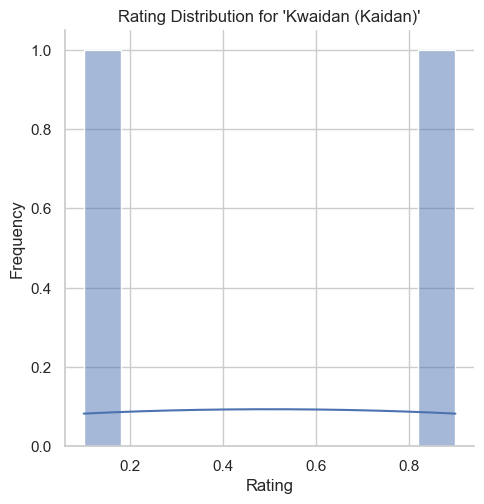

<Figure size 200x100 with 0 Axes>

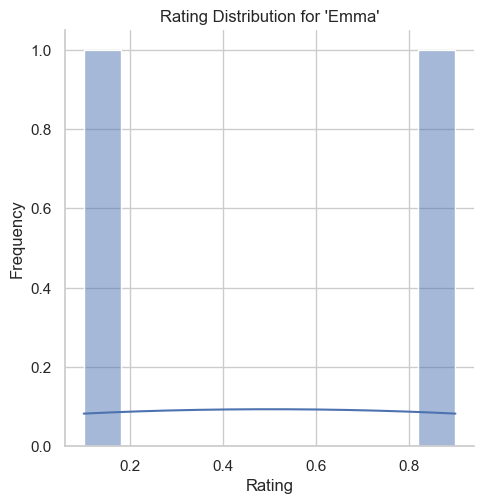

<Figure size 200x100 with 0 Axes>

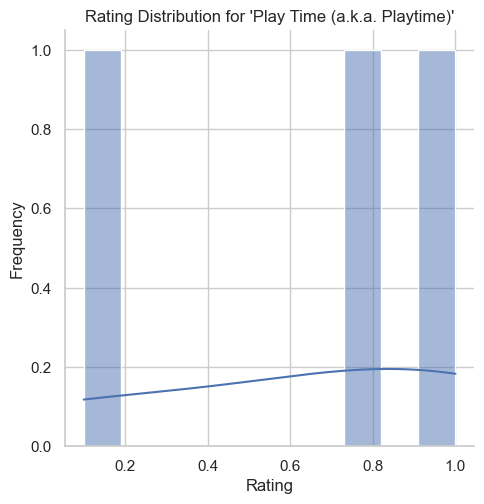

<Figure size 200x100 with 0 Axes>

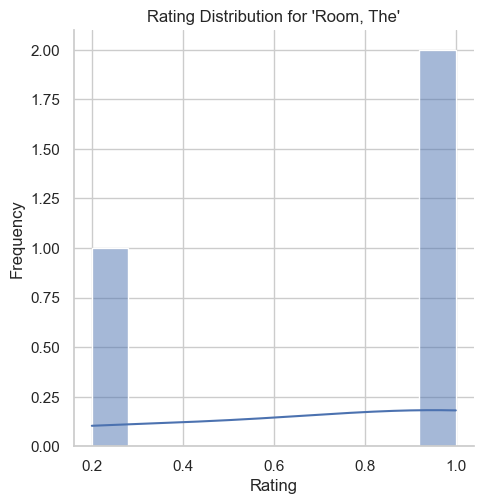

<Figure size 200x100 with 0 Axes>

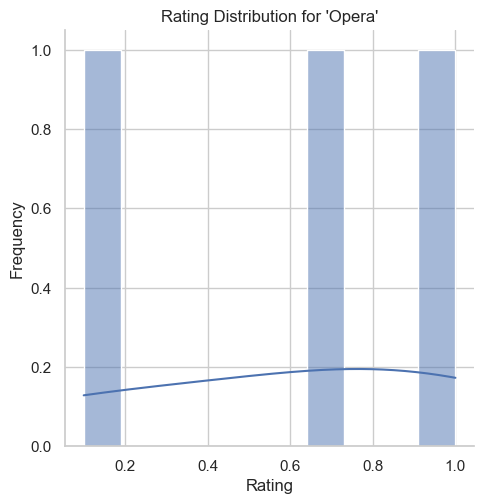

In [46]:

# Function to fetch and plot distribution for a specific movie
def plot_rating_distribution(movie_id, movie_title):
    # Fetch ratings for the specific movie
    ratings_data = list(db.movies_ratings.find({"movieId": movie_id}, {"rating": 1}))
    ratings_df = pd.DataFrame(ratings_data)

    # Plot the distribution of ratings
    plt.figure(figsize=(2, 1))
    sns.displot(ratings_df['rating'], kde = True, bins=10)
    #sns.histplot(ratings_df['rating'], kde=True, bins=10)
    plt.title(f"Rating Distribution for '{movie_title}'")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()

# Plot distribution for each of the top 10 movies
for movie in top_movies:
    movie_id = movie['_id']['movieId']
    movie_title = movie['_id']['movie']
    plot_rating_distribution(movie_id, movie_title)
    


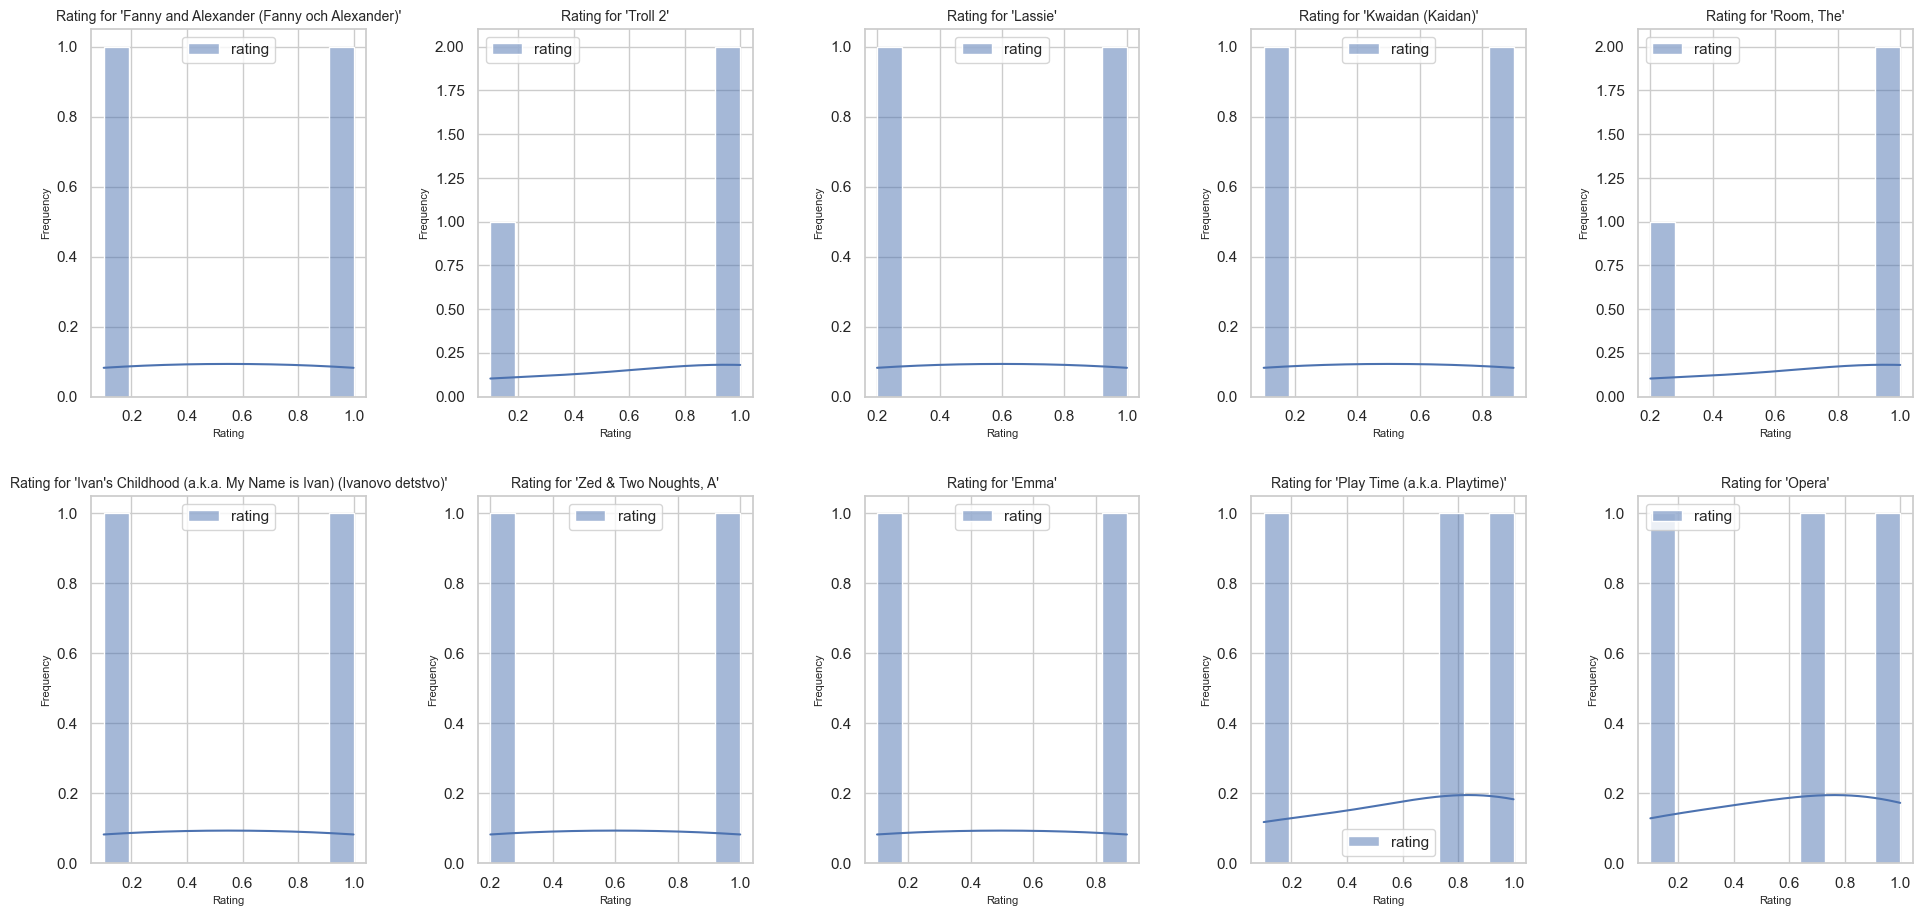

In [70]:
# 3 Function to plot rating distribution for a specific movie, same as before but different visualization 
def plot_rating_distribution(movie_id, movie_title, ax):
     # Fetch ratings for the specific movie
    ratings_data = list(db.movies_ratings.find({"movieId": movie_id}, {"rating": 1}))
    ratings_df = pd.DataFrame(ratings_data)
    

    sns.histplot(ratings_df, kde=True, bins=10, ax=ax)
    ax.set_title(f"Rating for '{movie_title}'", fontsize=10)
    ax.set_xlabel("Rating", fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)

# Create a 2x5 subplot matrix
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.tight_layout(pad=4.0)

# Plot distribution for each of the top 10 movies in the matrix
for i, movie in enumerate(top_movies):
    movie_id = movie['_id']['movieId']
    movie_title = movie['_id']['movie']
    row, col = divmod(i, 2)
    plot_rating_distribution(movie_id, movie_title, axes[col, row])

plt.show()

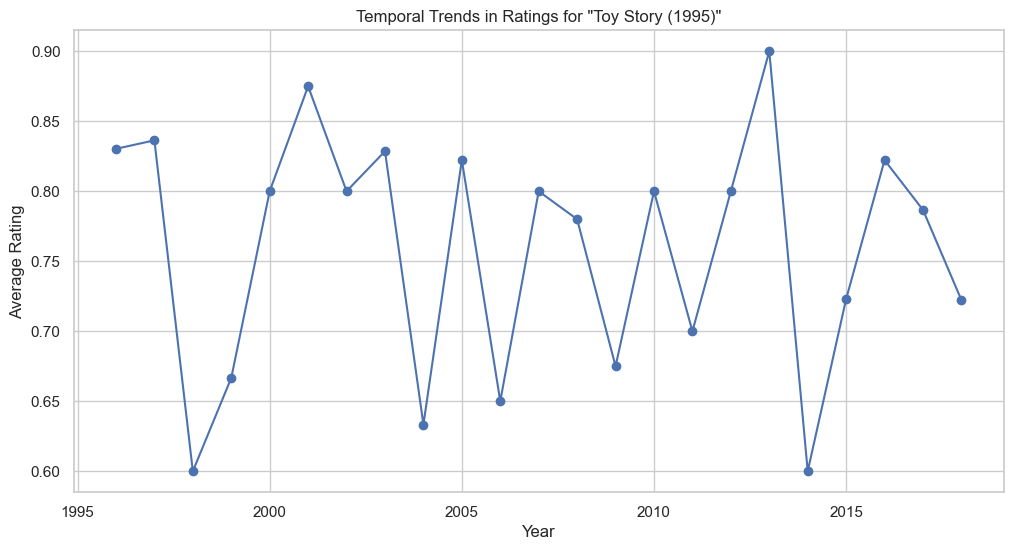

,year,averageRating
0,1996,0.830303
1,1997,0.836364
2,1998,0.600000
3,1999,0.666667
4,2000,0.800000


In [88]:


# MongoDB aggregation query 4
pipeline = [
    { "$match": { "title": "Toy Story" } },
    { "$project": { "year": { "$year": { "$toDate": "$timestamp" } }, "rating": 1 } },
    { "$group": { "_id": { "year": "$year" }, "averageRating": { "$avg": "$rating" }, "numRatings": {"$sum": 1} } },
    { "$sort": { "_id.year": 1 } }
]

# Execute the query
temporal_trends = list(db.movies_ratings.aggregate(pipeline))

# Ensure the DataFrame creation is correctly mapping the data
df = pd.DataFrame([{'year': item['_id']['year'], 'averageRating': item['averageRating']} for item in temporal_trends])

# Check if the DataFrame is created correctly
df.head()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['averageRating'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Temporal Trends in Ratings for "Toy Story (1995)"')
plt.grid(True)
plt.show()
df.head()

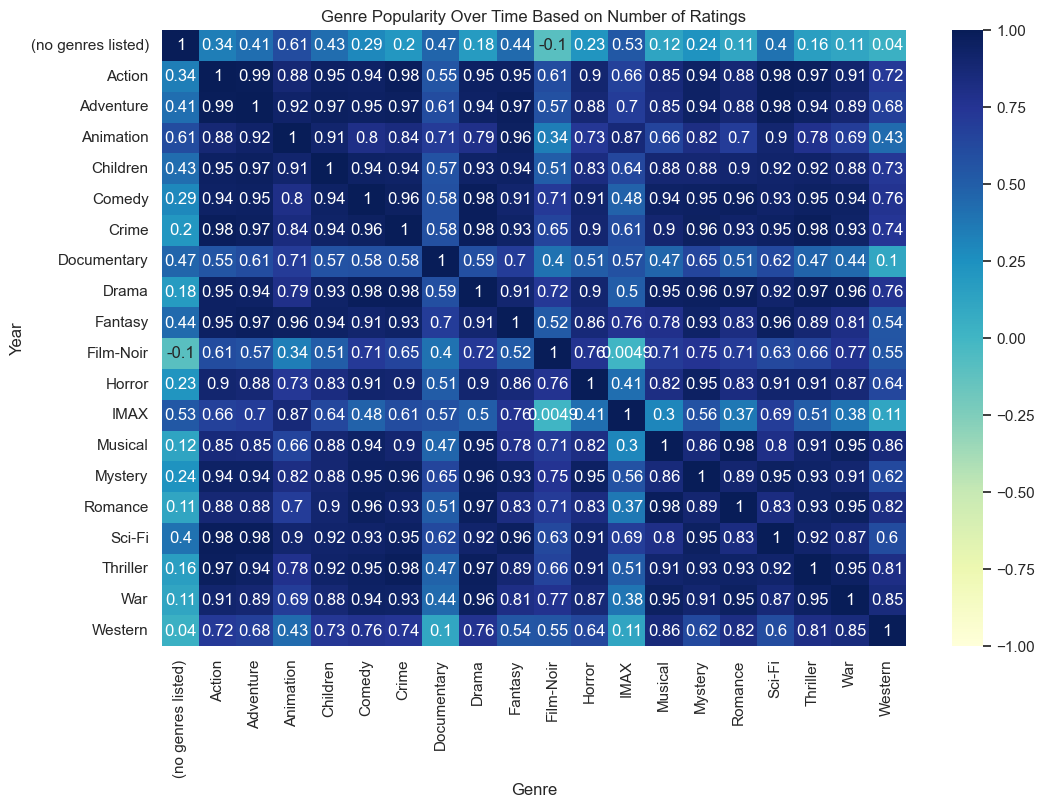

,year,genre,ratingCount
0,1996,Drama,2518
1,1996,Comedy,2250
2,1996,Thriller,1990
3,1996,Action,1964
4,1996,Adventure,1459


In [90]:

# MongoDB aggregation query 5
pipeline = [
    {"$project": {"year": {"$year": {"$toDate": "$timestamp"}}, "genres": 1}},
    {"$unwind": "$genres"},
    {"$group": {"_id": {"year": "$year", "genre": "$genres"}, "ratingCount": {"$sum": 1}}},
    {"$sort": {"_id.year": 1, "ratingCount": -1}}
]

# Execute the query
genre_popularity = list(db.movies_ratings.aggregate(pipeline))
# Convert to DataFrame
df = pd.DataFrame([{"year": item["_id"]["year"], "genre": item["_id"]["genre"], "ratingCount": item["ratingCount"]} for item in genre_popularity])

# Pivot the data for visualization
pivot_df = df.pivot(index='year', columns='genre', values='ratingCount').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df.corr(), annot = True, cmap = 'YlGnBu', vmin = -1, vmax = 1)
#sns.heatmap(pivot_df, cmap="YlGnBu", annot=False, cbar=True)
plt.title('Genre Popularity Over Time Based on Number of Ratings')
plt.xlabel('Genre')
plt.ylabel('Year')
plt.show()
df.head()

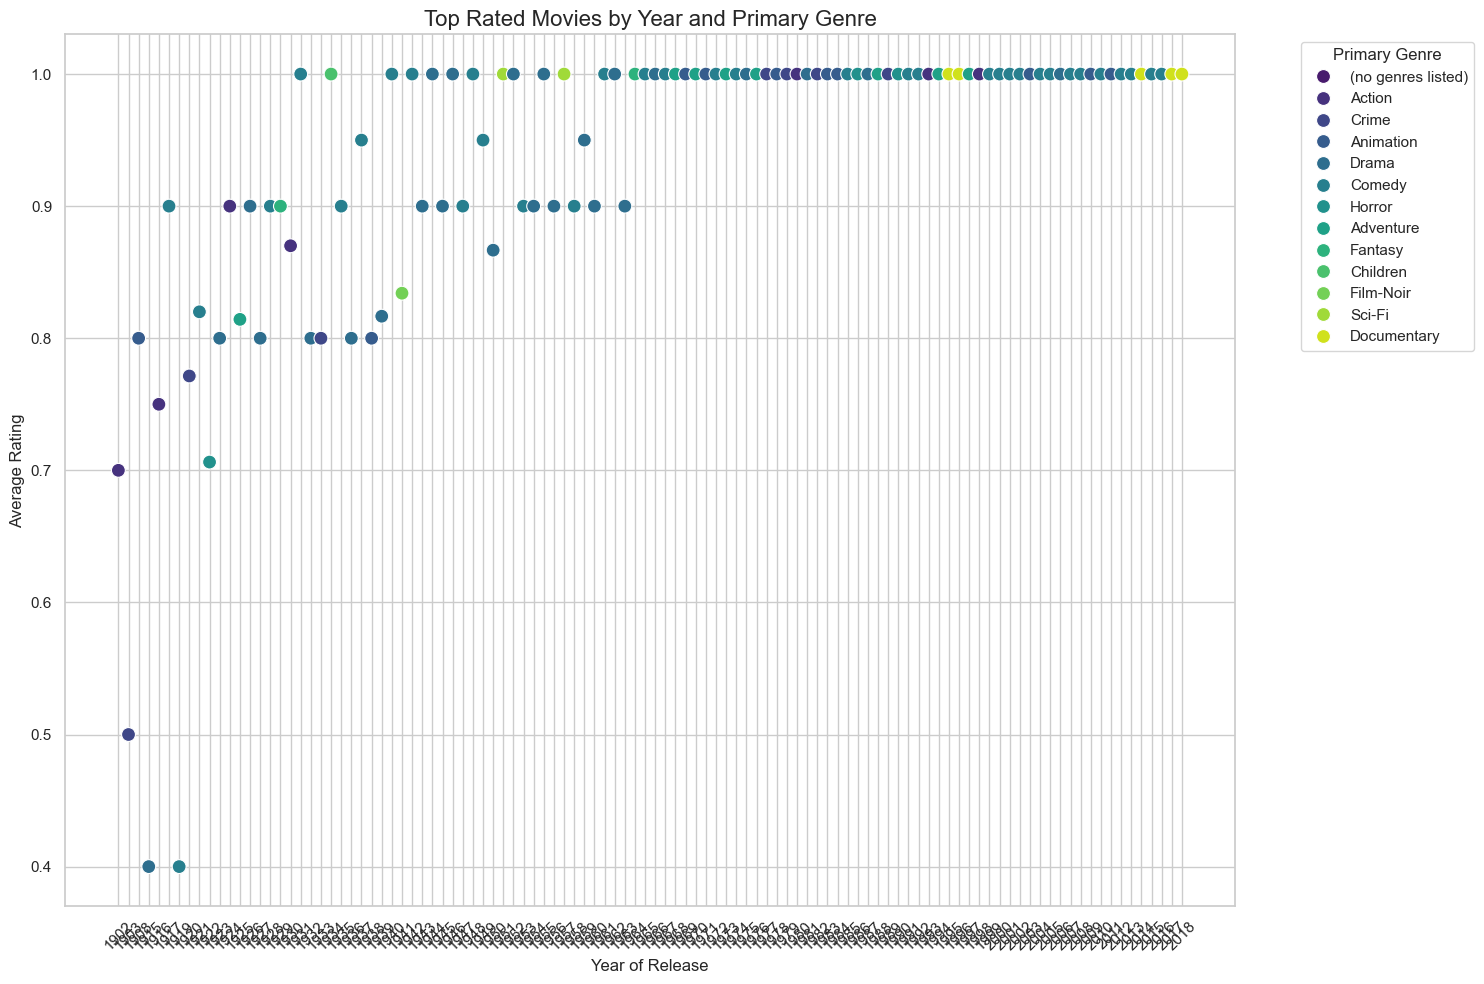

,release,title,genres,rating,primary_genre
0,None,Black Mirror,[(no genres listed)],1.0,(no genres listed)
1,1902,"Trip to the Moon, A (Voyage dans la lune, Le)","[Action, Adventure, Fantasy, Sci-Fi]",0.7,Action
2,1903,The Great Train Robbery,"[Crime, Western]",0.5,Crime
3,1908,The Electric Hotel,"[Animation, Comedy, Sci-Fi]",0.8,Animation
4,1915,"Birth of a Nation, The","[Drama, War]",0.4,Drama


In [92]:

# Perform the aggregation query 6
pipeline = [
    {
        "$group": {
            "_id": {"year": "$release", "movieId": "$movieId", "title": "$title", "genres": "$genres"},
            "averageRating": {"$avg": "$rating"}
        }
    },
    {"$sort": {"_id.year": 1, "averageRating": -1}},
    {
        "$group": {
            "_id": "$_id.year",
            "movie": {"$first": "$_id.title"},
            "genres": {"$first": "$_id.genres"},
            "averageRating": {"$first": "$averageRating"}
        }
    },
    {"$sort": {"_id": 1}}
]

results = list(db.movies_ratings.aggregate(pipeline))

# Convert the results into a pandas DataFrame
df = pd.DataFrame([{
    'release': r['_id'],
    'title': r['movie'],
    'genres': r['genres'],
    'rating': r['averageRating']
} for r in results])

# Convert the 'genres' list into a string of the first genre
df['primary_genre'] = df['genres'].apply(lambda x: x[0] if x else None)

# Visualizing the top-rated movies over the years
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='release', y='rating', hue='primary_genre', palette='viridis', s=100)
plt.title('Top Rated Movies by Year and Primary Genre', fontsize=16)
plt.xlabel('Year of Release', fontsize=12)

plt.xticks(rotation=45)
plt.ylabel('Average Rating', fontsize=12)
plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df.head()


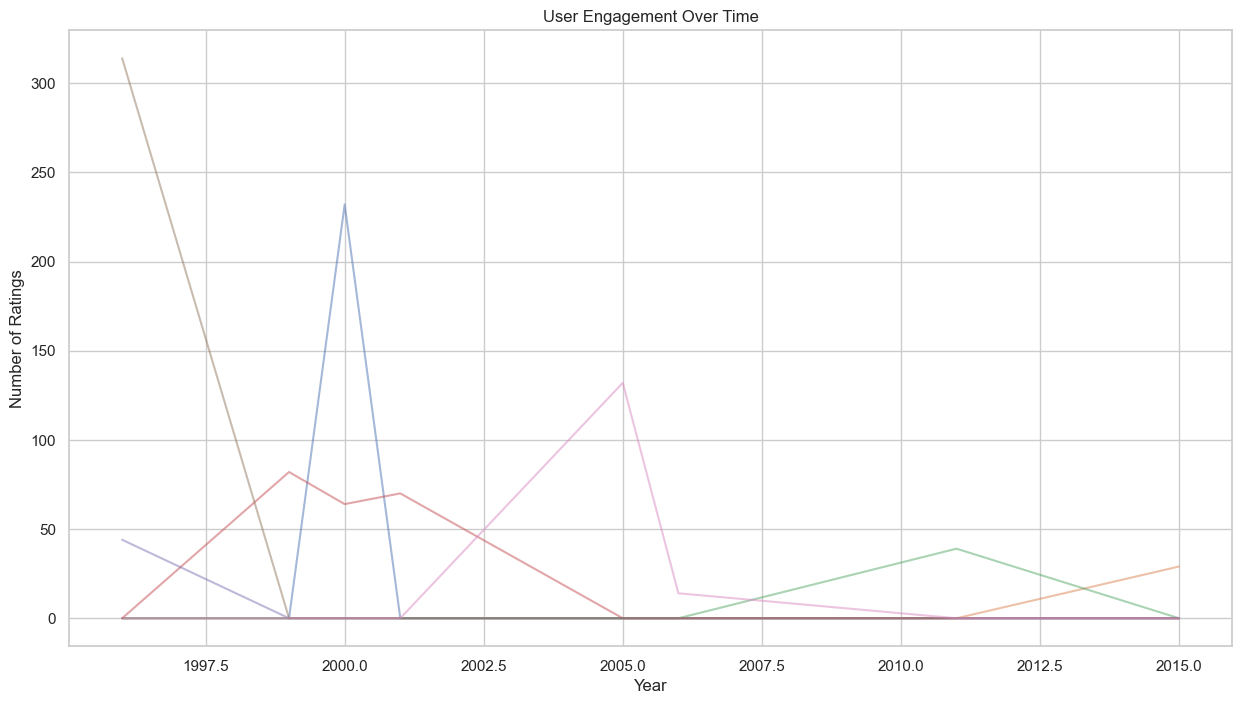

,userId,year,ratingCount
0,1,2000,232
1,2,2015,29
2,3,2011,39
3,4,1999,82
4,4,2000,64


In [93]:

# MongoDB aggregation query 7
pipeline = [
    {
        "$project": {
            "userId": 1,
            "year": {"$year": {"$toDate": "$timestamp"}}
        }
    },
    {
        "$group": {
            "_id": {"userId": "$userId", "year": "$year"},
            "ratingCount": {"$sum": 1}
        }
    },
    {"$sort": {"_id.userId": 1, "_id.year": 1}}
]

# Execute the query
result = list(db.movies_ratings.aggregate(pipeline))[:10]
# Convert the result to a DataFrame
df = pd.DataFrame([{'userId': x['_id']['userId'], 'year': x['_id']['year'], 'ratingCount': x['ratingCount']} for x in result])

# Pivot the DataFrame for visualization
pivot_df = df.pivot(index='year', columns='userId', values='ratingCount').fillna(0)

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(pivot_df, alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('User Engagement Over Time')

plt.show()
df.head()

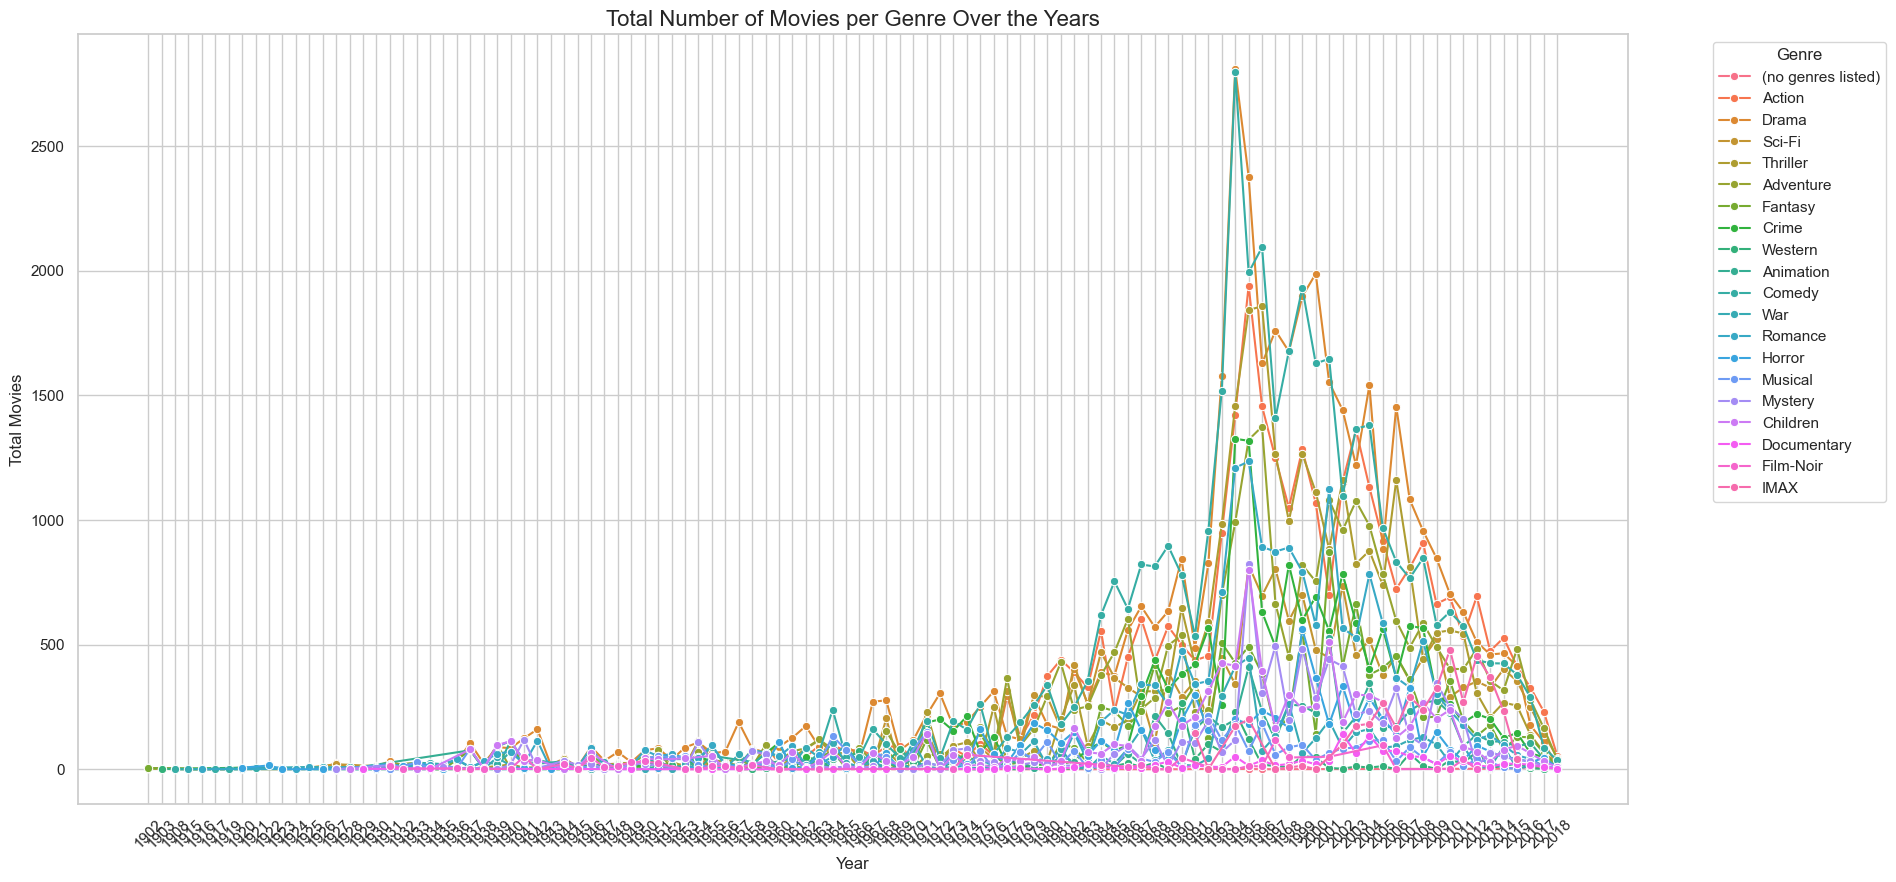

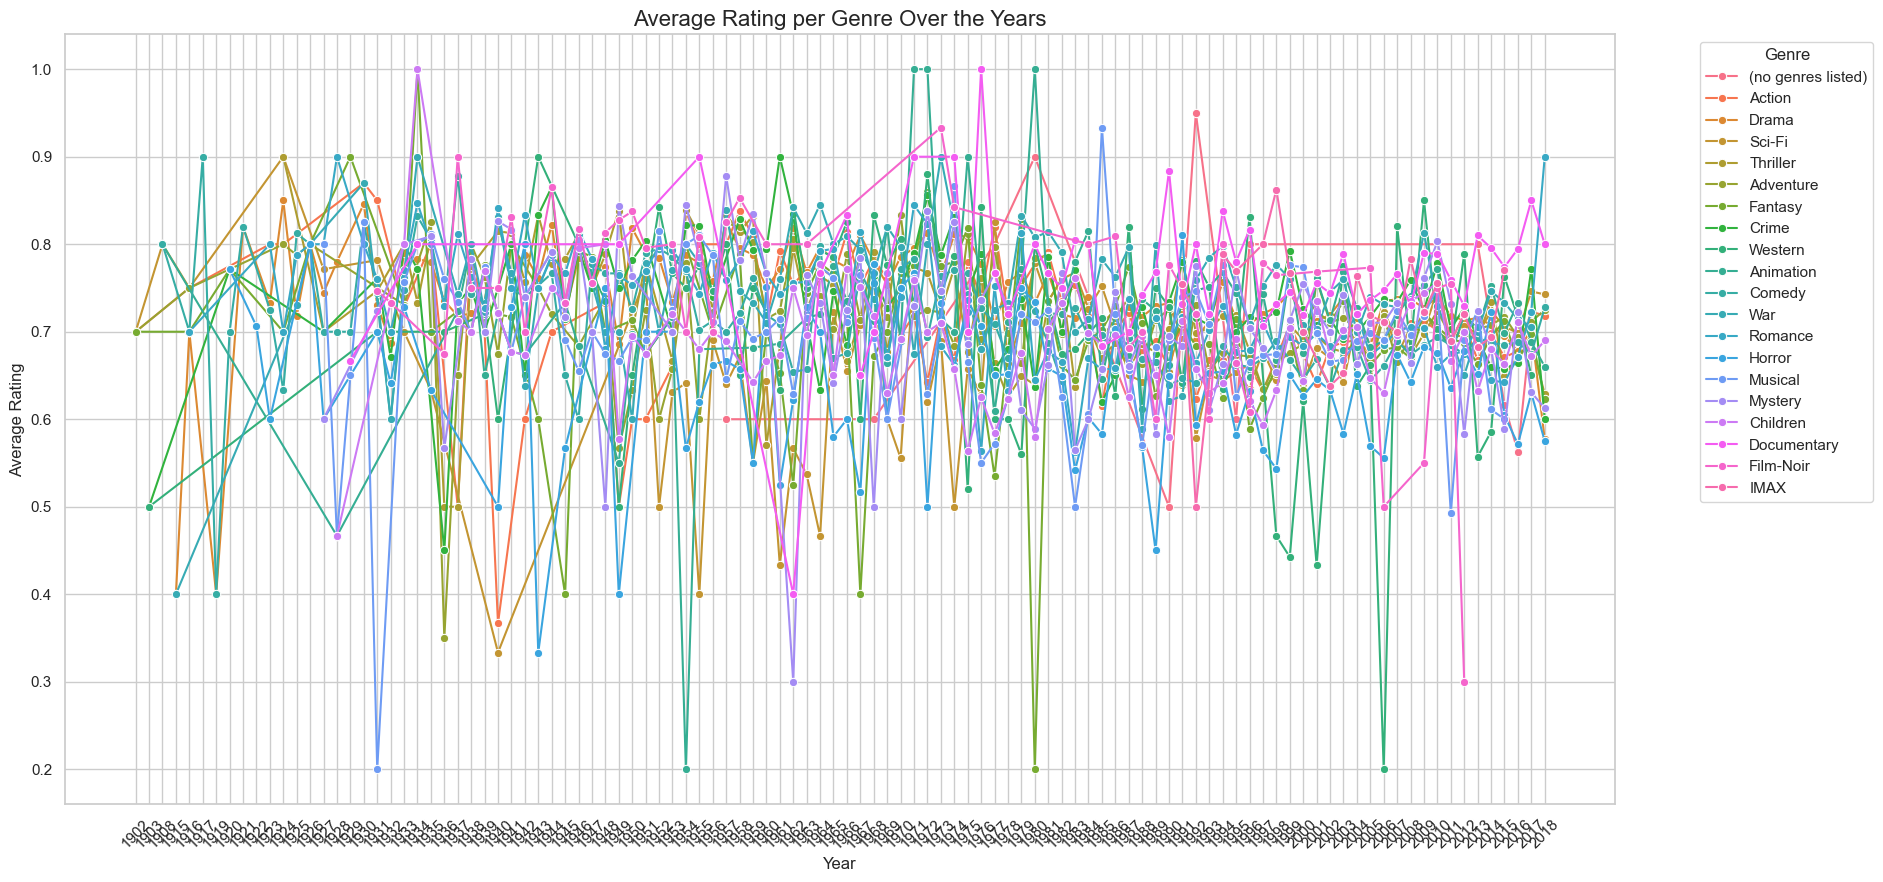

,year,genre,totalMovies,averageRating
0,None,(no genres listed),10,0.780000
1,None,Action,4,0.700000
2,None,Drama,2,0.800000
3,None,Sci-Fi,6,0.616667
4,None,Thriller,5,0.680000
...,...,...,...,...
1498,2018,Horror,8,0.575000
1499,2018,Mystery,8,0.612500
1500,2018,Romance,1,0.900000
1501,2018,Sci-Fi,47,0.742553


In [94]:

# Execute the aggregation query 8
pipeline = [
    { "$unwind": "$genres" },
    {
        "$project": {
            "releaseYear": "$release",
            "genres": 1,
            "rating": 1
        }
    },
    {
        "$group": {
            "_id": { "year": "$releaseYear", "genre": "$genres" },
            "totalMovies": { "$sum": 1 },
            "averageRating": { "$avg": "$rating" }
        }
    },
    { "$sort": { "_id.year": 1, "_id.genre": 1 } }
]

results = list(db.movies_ratings.aggregate(pipeline))

# Convert results to a DataFrame
df = pd.DataFrame([{
    'year': r['_id']['year'],
    'genre': r['_id']['genre'],
    'totalMovies': r['totalMovies'],
    'averageRating': r['averageRating']
} for r in results])

# Plotting
plt.figure(figsize=(20, 10))

# Plot for total movies per genre over the years
sns.lineplot(data=df, x='year', y='totalMovies', hue='genre', marker='o')
plt.title('Total Number of Movies per Genre Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Total Movies', fontsize=12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Plot for average rating per genre over the years
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='year', y='averageRating', hue='genre', marker='o')
plt.title('Average Rating per Genre Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)


plt.xticks(rotation=45)
plt.ylabel('Average Rating', fontsize=12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
df

/var/folders/hj/yw5tr4wj21jcnjgpw0w3kf3m0000gn/T/ipykernel_52155/2714020409.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month', y='averageRating', palette='coolwarm')


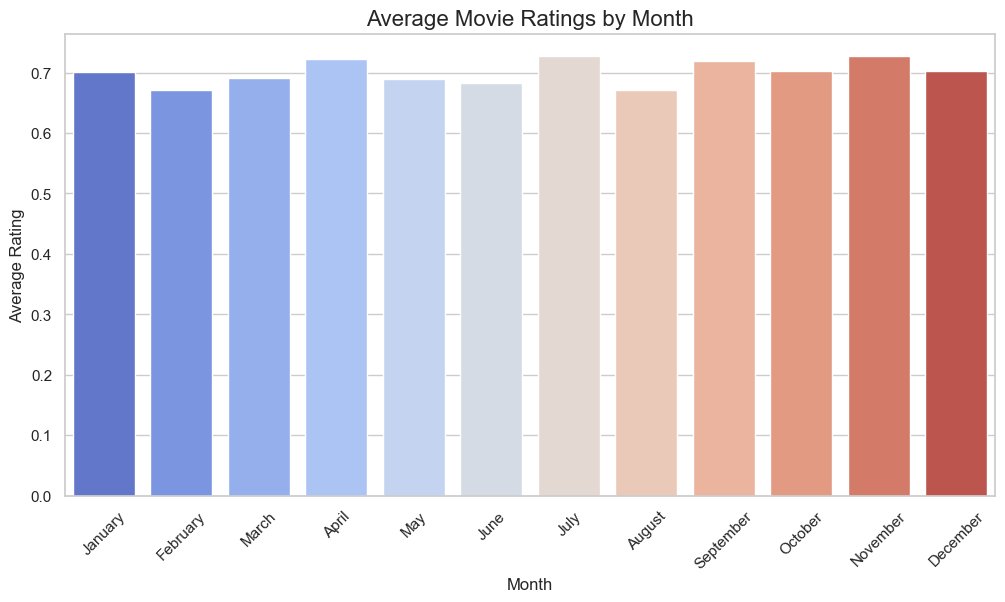

,month,averageRating
0,January,0.700749
1,February,0.670399
2,March,0.691104
3,April,0.722700
4,May,0.690113
5,June,0.683445
6,July,0.727986
7,August,0.671810
8,September,0.719965
9,October,0.702532


In [96]:

# Execute the aggregation query 9
pipeline = [
    {
        "$project": {
            "month": { "$month": { "$toDate": "$timestamp" } },
            "rating": 1
        }
    },
    {
        "$group": {
            "_id": "$month",
            "averageRating": { "$avg": "$rating" }
        }
    },
    { "$sort": { "_id": 1 } }
]

results = list(db.movies_ratings.aggregate(pipeline))

# Convert results to a DataFrame
df = pd.DataFrame([{
    'month': r['_id'],
    'averageRating': r['averageRating']
} for r in results])

# Map month numbers to names for better readability
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df['month'] = df['month'].map(month_names)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='month', y='averageRating', palette='coolwarm')
plt.title('Average Movie Ratings by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()
df


In [97]:

# Execute the aggregation query 10
pipeline = [
    {
        "$group": {
            "_id": {"movieID": "$movieId", "movieTitle": "$title"},
            "averageRating": { "$avg": "$rating" },
            "ratingCount": { "$sum": 1 }
        }
    }
]

results = list(db.movies_ratings.aggregate(pipeline))

# Convert results to a DataFrame
df = pd.DataFrame([{
    'movieID': r['_id']['movieID'],
    'movieTitle': r['_id']['movieTitle'],
    'averageRating': r['averageRating'], 
    'ratingCount': r['ratingCount']
} for r in results])
df

,movieID,movieTitle,averageRating,ratingCount
0,270,Love Affair,0.680000,5
1,7316,Confessions of a Teenage Drama Queen,0.475000,4
2,48322,Jackass Number Two,0.714286,7
3,1479,"Saint, The",0.643333,30
4,91323,"Sitter, The",0.580000,5
...,...,...,...,...
9719,6545,I Capture the Castle,0.900000,1
9720,26947,Pusher,0.500000,1
9721,4354,Unlawful Entry,0.500000,1
9722,6950,"Missing, The",0.733333,3


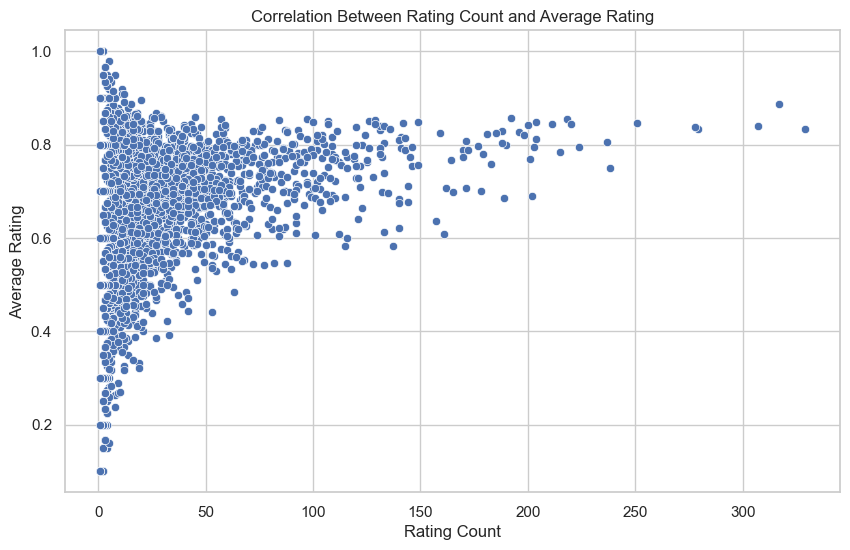

In [85]:

# Setting the theme for seaborn
sns.set_theme(style="whitegrid")

# Creating a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ratingCount', y='averageRating')

# Adding titles and labels
plt.title('Correlation Between Rating Count and Average Rating')
plt.xlabel('Rating Count')
plt.ylabel('Average Rating')

# Display the plot
plt.show()
